In [1]:
import gurobipy as gb
from gurobipy import *
import numpy as np
import pandas as pd
from random import random

#### III.2. Variables and Notations (from fields to continuous number of fields)

Let $J = \{0, ..., 11\}$ the studied crops, $K = \{0, ..., 5\}$ the rotation's years and $K' = K \backslash \{5\}$. Let $V = I \times J \times K$.

We use now as an input the data from the census of agriculture of Canada from 2021. It allows us to have precise numbers and a better geographical granularity.

##### a. Fields definition

The grid is divided in areas that we will call each $i$. Thus, let $I = \{0, ..., N_{areas} - 1\}$ the set of indices of our areas.

As dividing the areas by fields would create too many variables, and lead to binary decision variables, let's consider for each area the number of field of a specific size allocated to one crop, knowing teh previous crop harvested last year.

Let's define the size of fields. For this, we take back the distribution of Lesiv et al. (2018). Instead of generating fields for each area, let's fix the type of size to the 5 defined by Lesiv et al. and fix the surface to the average of each range.

|Field Size ($s$)|Surface (in ha)|Distribution (in %) - $p_s$|
|--------------|---------------|-------------------|
|Very Small    |0.32           |4                  |
|Small         |1.6            |5                  |
|Medium        |9.28           |19                 |
|Large         |58             |61                 |
|Very Large    |200            |11                 |

Let's note $S = \{0, ..., 4\}$ the set of field sizes.

##### b. Crop on crop allocation - Number of fields

To modelize the succession of choice of crop between years, we introduce the following graph for each area $i$:

$$ G_{i} = (X_i, V_i)$$

To simplify the notation, we avoid to add an extra $i$ index and note each vertex of this graph: $\forall (j, k) \in J \times S \times K, j_{s, k} = (j, s, k)$.

The edges are defined by $x_{j_{s,k}, l_{r, m}}$ as the number of fields of size $r$ where crop $l$ in year $m$ are planted knowing that crop $j$ in year $k$ has been harvested in fields of size $s$.

We consider that the edges are only defined year on year (we respect the chronological order), which leads to the following constraints:

$$ \forall j_{s,k}, l_{r, m} \in (J \times S \times K)^2, x_{j_{s,k}, l_{r, m}} = 0 \text{ if } m \neq k+1 \text{ or } (k,m) \neq (5,0)$$

For the rest of the study, we will simplify the size of X to the following: $X_{f_i} \in J^2 \times S^2 \times K$ as for each year $k$, we need to assess if we take the path between each couple $(j,l) \in J^2$. Considering that all edges from k to k + 1 can be assigned to year k, we can write in a simple form: 

$$ \forall j, l, s, r, k \in J^2 \times S^2 \times K', x_{j_{s, k}, l_{r, k+1}} = x_{j_s,l_r}^k$$

$$ \forall j, l \in J^2 \times S^2, x_{j_{s,5}, l_{r,0}} = x_{j_s,l_r}^5$$

Thus, we have now:

$$ \forall i \in I, X_{i} = (x_{j_s,l_r}^k)$$

Degree constraint: 

The total area allocated to crop $l$ in field of size $r$ in year $k+1$ is given by the following sum: $$\sum_{j \in J, s \in S} x_{j_s, l_r}^k \times S_s$$
with $S_s$ being the size defined for the field of size s.

The surface allocated to one node should be equal to the surface used next year from this node, hence the degree constraint:

$$\forall l_r, k \in J \times S \times K', \sum_{j \in J, s \in S} x_{j_s, l_r}^k \times S_s = \sum_{j \in J, s \in S} x_{l_r, j_s}^{k+1} \times S_r$$

$$\forall l_r \in J \times S, \sum_{j \in J, s \in S} x_{j_s, l_r}^5 \times S_s = \sum_{j \in J, s \in S} x_{l_r, j_s}^0 \times S_r$$

Field size distribution:

The advantage of the previous method was that we were able to define the field sizes based on the given distribution defined by Lesiv et al.. Now the distribution becomes the following constraints:

$$ \forall s, k \in S \times K, p_s \times \sum_{l \in J, r \in S} \sum_{j \in J, s \in S} x_{j_s, l_r}^k  = \sum_{l \in J} \sum_{j \in J, s \in S} x_{j_s, l_r}^k$$

##### c. Surface allocated per crop

Let's define the minimum surface to allocate to each crop.

Let's start with noting the actual surface allocated on average to each crop as per the 32-10-0359-01 Table from Statistic Canada:
$$\forall (i,j) \in I \times J, A_{i,j}$$

We want to use this as the demand but yet, let's be flexible and ask for each crop to have only 80% of the demand, hence the following constraint:

$$\forall (i,l,k) \in V, \sum_{r \in S} \sum_{j \in J, s \in S} x_{j_s, l_r}^k \times S_s \ge 0.8A_{i,l}$$

##### d. Nutrients needs

Now that we have the numbers ${x_{j_s,l_r}^k}$, we are able to compute what are the amounts of nutrients to bring for each fields.

The formula is for all size of fields fields and to all nutrients $N = \{N, P_2O_5, K_2O, S\}$:

$$ \forall (n,l_r, k) \in (N \times S \times J \times K), Q_{n, l_r, k} = \sum_{j \in J, s \in S} x_{j_s, l_r}^k \times S_s \times (n(Up)_l - n(Up)_j + n(Re)_j)$$

##### e. Decision variables

Let's resume the decision variables:

|Variables          |Description                                                                       |Type                              |Number                                       |
|-------------------|----------------------------------------------------------------------------------|----------------------------------|---------------------------------------------|
|$$X_i$$            |Set of number of fields allocated from size on size, crop on crop, year on year   |Continuous                        |$$Card(I \times J^2 \times S^2 \times K)$$     |
|$$(p_r^k)_i$$      |Set of proportions                                                                |Continuous                        |$$Card(I \times S \times K)$$|


##### f. Objective function

Our objective is to limit the need to bring additional nutrients to the field. Thus, our first objective function would be:

$$ \min \sum_{N,S,J,K} Q_{n, l_r, k} $$

##### g. Constraints

|Description                                                                   |Formula                                                        |
|------------------------------------------------------------------------------|---------------------------------------------------------------|
|Yearly allocation of crops has to reach 80% of the actual surface seeded      |$$\forall (i,l,k) \in V, \sum_{r \in S} \sum_{j \in J, s \in S} x_{j_s, l_r}^k \times S_s \ge 0.8A_{i,l}$$              |
|Degree constraints - Surface Conservation                        |$$\forall l_r, k \in J \times S \times K', \sum_{j \in J, s \in S} x_{j_s, l_r}^k \times S_s = \sum_{j \in J, s \in S} x_{l_r, j_s}^{k+1} \times S_r$$ <br> $$\forall l_r \in J \times S, \sum_{j \in J, s \in S} x_{j_s, l_r}^5 \times S_s = \sum_{j \in J, s \in S} x_{l_r, j_s}^0 \times S_r$$|
|Field distribution |$$ \forall s, k \in S \times K, p_s \times \sum_{l \in J, r \in S} \sum_{j \in J, s \in S} x_{j_s, l_r}^k  = \sum_{l \in J} \sum_{j \in J, s \in S} x_{j_s, l_r}^k$$|


Let's code and see what are the results!

In [3]:
# Define the data

J = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Crops = [
    "Spring Wheat",
    "Winter Wheat",
    "Barley",
    "Oats",
    "Rye",
    "Corn",
    "Canola",
    "Soybeans",
    "Peas",
    "Lentils",
    "Grass",
    "Corn Silage",
]
K = [0, 1, 2, 3, 4, 5]

# Crop needs

uptake = [
    [85, 32, 73, 9],     # Spring Wheat
    [67, 30, 70, 10],    # Winter Wheat
    [111, 45, 106, 13],  # Barley
    [116, 40, 145, 13],  # Oats
    [92, 45, 130, 15],   # Rye
    [153, 63, 128, 15],  # Corn
    [112, 52, 81, 19],   # Canola
    [180, 31, 129, 12],  # Soybeans
    [153, 43, 136, 12],  # Peas
    [92, 25, 76, 9],     # Lentils
    [102, 30, 130, 13],  # Grass
    [156, 63, 201, 13],  # Corn Silage
]

removal = [
    [60, 23, 18, 5],     # Spring Wheat
    [52, 25, 17, 7],     # Winter Wheat
    [77, 34, 26, 7],     # Barley
    [61, 25, 18, 5],     # Oats
    [58, 24, 20, 5],     # Rye
    [97, 44, 27, 6],     # Corn
    [68, 37, 18, 11],    # Canola
    [135, 29, 49, 4],    # Soybeans
    [117, 35, 35, 6],    # Peas
    [62, 18, 33, 5],     # Lentils
    [102, 30, 130, 13],  # Grass
    [156, 63, 201, 13],  # Corn Silage
]

# Translate lb/acre to kg/ha

uptake = np.array(uptake) * 1.12085
removal = np.array(removal) * 1.12085

S = [0, 1, 2, 3, 4]

Surface = [0.32, 1.6, 9.28, 58, 200]

p = [0.04, 0.05, 0.19, 0.61, 0.11]

list_crops = [
    "BARLEY_M",
    "OTTAME_M",
    "CANOLA_M",
    "CORNGR_M",
    "CORNSI_M",
    "DFPEAS_M",
    "LENTIL_M",
    "OATS_M",
    "SOYBNS_M",
    "TOTRYE_M",
    "WHTSPG_M",
    "WHTWIN_M"
]

In [4]:
# Divide the areas with their respected fields

A = pd.read_csv("crop_alberta.csv", index_col="CCSUID")
A = A.drop(columns=["CCSNAME","SRUNOM"])
A = A.clip(lower=0)

# Change the name of the columns to match the Crops
A.columns = Crops

CCSUID = A.index.tolist()

A.head()

,Spring Wheat,Winter Wheat,Barley,Oats,Rye,Corn,Canola,Soybeans,Peas,Lentils,Grass,Corn Silage
CCSUID,,,,,,,,,,,,
4801003,43167.0,0.0,20906.0,2091.0,1635.0,0.0,23237.0,0.0,20137.0,13778.0,10460.0,1631.0
4801008,63724.0,4846.0,40076.0,2946.0,2460.0,0.0,44214.0,0.0,31745.0,49957.0,3191.0,0.0
4802001,35461.0,8392.0,43327.0,1150.0,3287.0,0.0,43364.0,0.0,17465.0,28351.0,5208.0,7237.0
4802011,54277.0,9021.0,74324.0,3748.0,5972.0,4582.0,65286.0,553.0,17650.0,9572.0,10054.0,12679.0
4802021,44949.0,5216.0,28457.0,1146.0,0.0,5136.0,33353.0,0.0,12257.0,7899.0,4533.0,2937.0


In [5]:
# Implementation of the model

m = gb.Model("Crop-rotation Optimization - Number of Fields")

Set parameter Username
Set parameter LicenseID to value 2704635
Academic license - for non-commercial use only - expires 2026-09-08


In [6]:
# Decision variables

x = m.addVars(
    [(ccs, j, s, l, r, k)
                        for ccs in CCSUID
                        for j in J
                        for s in S
                        for l in J
                        for r in S
                        for k in K],
    lb = 0,
    vtype=gb.GRB.CONTINUOUS,
    name=lambda tpl: f"x_{ccs}_{j}_{s}_{l}_{r}_{k}"
)

In [7]:
# Computation of the quantities of nutrients to bring

Q = {}
for ccs in CCSUID:
    for n in range(len(uptake[0])):
        for j in J:
            for s in S:
                for l in J:
                    for r in S:
                        for k in K:
                            Q[ccs, n, j, s, l, r, k] = x[ccs, j, s, l, r, k] * Surface[s] * (uptake[l][n] - uptake[j][n] + removal[j][n])


In [8]:
# Objective function

m.setObjective(sum(Q[ccs, n, j, s, l, r, k] for ccs in CCSUID for n in range(len(uptake[0])) for j in J for s in S for l in J for r in S for k in K), GRB.MINIMIZE)

In [9]:
# Add Constraints

m.addConstrs((sum(x[ccs, j, s, l, r, k] * Surface[s] for j in J for s in S for r in S) >= 0.8 * float(A.loc[ccs][Crops[l]]) for ccs in CCSUID for l in J for k in K), name="Demand")
m.addConstrs((sum(x[ccs, j, s, l, r, k] * Surface[s] for j in J for s in S) == sum(x[ccs, l, r, j, s, k+1] * Surface[r] for j in J for s in S) for ccs in CCSUID for l in J for r in S for k in K[:len(K)-1]), name="Surface Conservation")
m.addConstrs((sum(x[ccs, j, s, l, r, len(K) - 1] * Surface[s] for j in J for s in S) == sum(x[ccs, l, r, j, s, 0] * Surface[r] for j in J for s in S) for ccs in CCSUID for l in J for r in S), name="Surface Conservation")
m.addConstrs((sum(x[ccs, j, s, l, r, k] for l in J for j in J for s in S) == p[r] * sum(x[ccs, j, s, l, r, k] for l in J for r in S for j in J for s in S) for ccs in CCSUID for r in S for k in K), name="Field Distribution")
#m.addConstrs(Q[ccs, n, j, s, l, r, k] >= 0 for ccs in CCSUID for n in range(len(uptake[0])) for j in J for s in S for l in J for r in S for k in K)

{(4801003, 0, 0): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 0, 2): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 0, 4): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 0, 5): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 1, 0): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 1, 5): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 2, 0): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 2, 2): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 2, 3): <gurobi.Constr *Awaiting Model Update*>,
 (4801003, 2, 4): <gurobi.Constr *Awaiting Model Update*

In [10]:
# Solve the model

m.Params.MIPGap = 1e-3   # stop when gap <= 0.1% (0.001)
m.optimize()

Set parameter MIPGap to value 0.001
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.1.0 24B83)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  0.001

Optimize a model with 33264 rows, 1555200 columns and 12441600 nonzeros
Model fingerprint: 0xc66318ca
Coefficient statistics:
  Matrix range     [4e-02, 2e+02]
  Objective range  [7e-01, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+05]
Presolve removed 2160 rows and 0 columns
Presolve time: 1.28s
Presolved: 31104 rows, 1555200 columns, 11793600 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.665e+05
 Factor NZ  : 1.731e+05 (roughly 100 MB of memory)
 Factor Ops : 8.186e+06 (less than 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal  

/opt/anaconda3/envs/MGSC662/lib/python3.12/site-packages/matplotlib/collections.py:999: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/opt/anaconda3/envs/MGSC662/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:1688: RuntimeWarning: invalid value encountered in sqrt
  return self.np.sqrt(marker_size) / 2


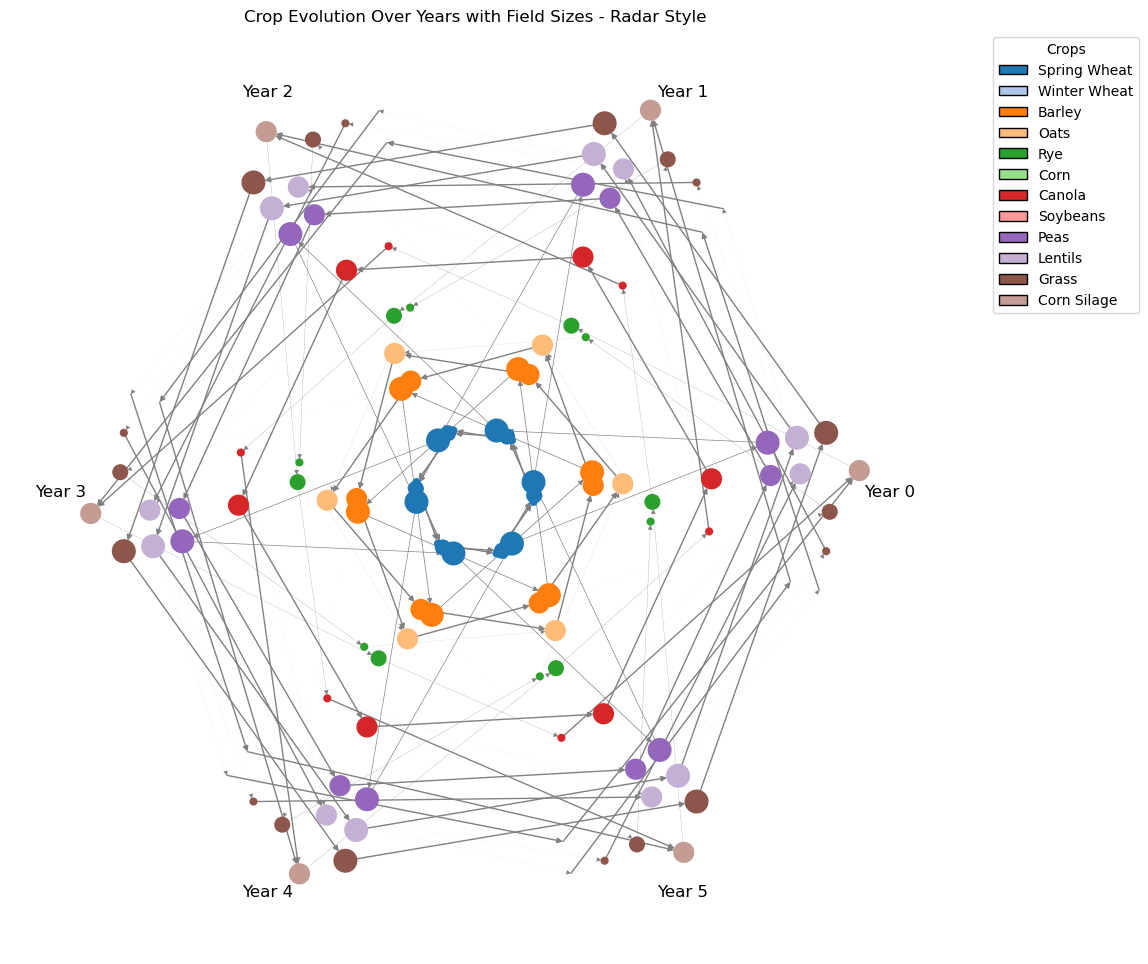

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

ccs_choice = CCSUID[0]
num_crops = len(Crops)
num_years = len(K)
radius_step = 20  # distance between crops along each year spoke

G = nx.DiGraph()
pos = {}

# Generate a distinct color for each crop

cmap = plt.get_cmap("tab20")  # up to 20 distinct colors
crop_colors = {crop: cmap(i % 20) for i, crop in enumerate(Crops)}

# -----------------------------

# Create positions: radial layout

# Years = circle vertices

# Crops = along spokes

# Field sizes = additional distance scaling

# -----------------------------

angle_offset = 0.1
r_offset = 20
for k, year in enumerate(K):
    angle_base = 2 * np.pi * k / num_years
    for j, crop in enumerate(Crops):
        for s in S:  # field size
            angle = angle_base + (s - len(S)/2) * angle_offset
            size_offset = 0.8
            r = r_offset + (j + 1) * radius_step
            x_0 = r * np.cos(angle)
            y_0 = r * np.sin(angle)
            node_id = f"{crop} (Year {year}, Size {Surface[s]})"
            # Aggregate value from solution
            value = sum(x[ccs_choice, j, s, l, r_idx, k_idx].X for l in J for r_idx in S for k_idx in K if k_idx == k)
            if value > 0.00001:
                G.add_node(node_id, value=value, crop=crop, size=Surface[s])
                pos[node_id] = (x_0, y_0)

# -----------------------------

# Add edges between consecutive years for each crop and size

# -----------------------------

for j, crop_j in enumerate(Crops):
    for s in S:
        for k, year in enumerate(K):
            for l, crop_l in enumerate(Crops):
                for r_idx in S:
                    src = f"{crop_j} (Year {year}, Size {Surface[s]})"
                    dst = f"{crop_l} (Year {year+1}, Size {Surface[r_idx]})" if k < num_years - 1 else f"{crop_l} (Year {0}, Size {Surface[r_idx]})"
                    if src in G.nodes and dst in G.nodes:
                        weight = x[ccs_choice, j, s, l, r_idx, k].X
                        if weight > 0.00001:
                            G.add_edge(src, dst, weight=weight)

# -----------------------------

# Plot

# -----------------------------

plt.figure(figsize=(12, 12))
plt.axis("off")

# Node sizes scaled by value

node_sizes = [np.log(G.nodes[n]["size"]) * 50 for n in G.nodes()]  # scale factor

# Node colors based on crop

node_colors = [crop_colors[G.nodes[n]["crop"]] for n in G.nodes()]

# Edge widths scaled

edge_widths = [G[u][v]["weight"] / max(1, max(G.nodes[u]["value"], G.nodes[v]["value"])) for u, v in G.edges()]

nx.draw(
    G,
    pos,
    with_labels=False,
    node_size=node_sizes,
    node_color=node_colors,
    edge_color="gray",
    width=edge_widths,
    arrows=True,
    arrowsize=8
)

# -----------------------------

# Year labels around circle

# -----------------------------

for k, year in enumerate(K):
    angle = 2 * np.pi * k / num_years
    x_text = (num_crops + 2) * (radius_step) * np.cos(angle)
    y_text = (num_crops + 2) * (radius_step) * np.sin(angle)
    plt.text(x_text, y_text, f"Year {year}", ha="center", va="center", fontsize=12)

# -----------------------------

# Legend for crop colors

# -----------------------------

legend_elements = [Patch(facecolor=color, edgecolor='k', label=crop) for crop, color in crop_colors.items()]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Crops")

plt.title("Crop Evolution Over Years with Field Sizes - Radar Style")
plt.show()

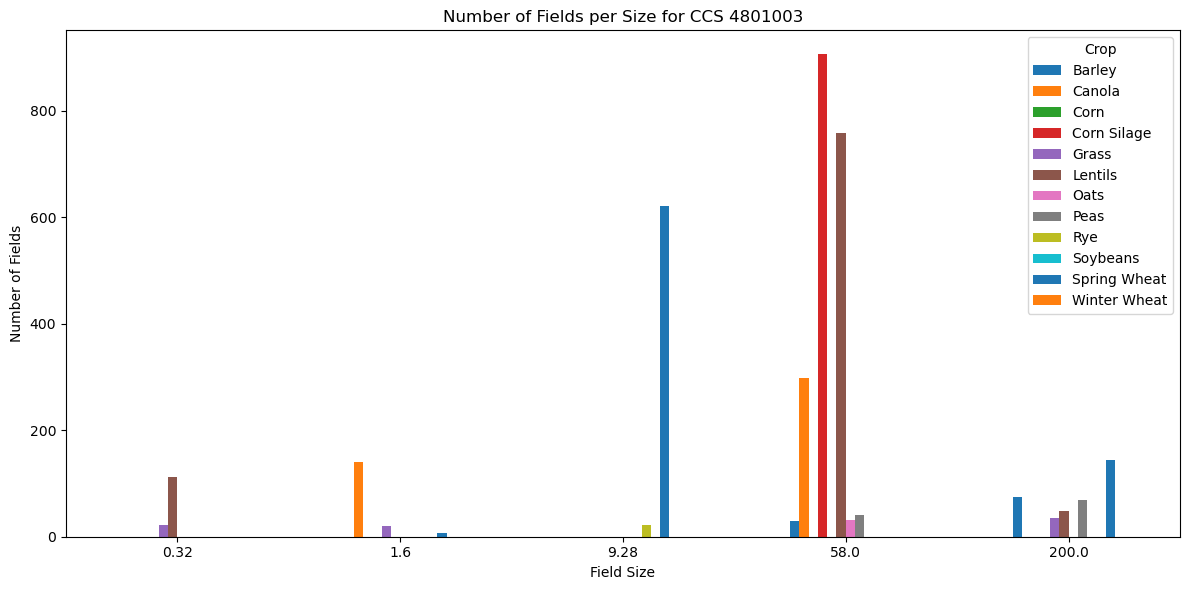

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Choose CCS to visualize

ccs_choice = CCSUID[0]  # replace with desired CCS
k_choice = K[0]

# Aggregate solution

data = []
for l in J:  # crop index
    crop_name = Crops[l]
    for r in S:  # field size
        total_fields = sum(x[ccs_choice, j, s, l, r, k_choice].X for j in J for s in S)
        data.append({'Crop': crop_name, 'Size': Surface[r], 'Fields': total_fields})

    df = pd.DataFrame(data)

# Pivot table for easier plotting

pivot = df.pivot(index='Size', columns='Crop', values='Fields').fillna(0)

# Plot

pivot.plot(kind='bar', figsize=(12,6))
plt.title(f'Number of Fields per Size for CCS {ccs_choice}')
plt.xlabel('Field Size')
plt.ylabel('Number of Fields')
plt.xticks(rotation=0)
plt.legend(title='Crop')
plt.tight_layout()
plt.show()

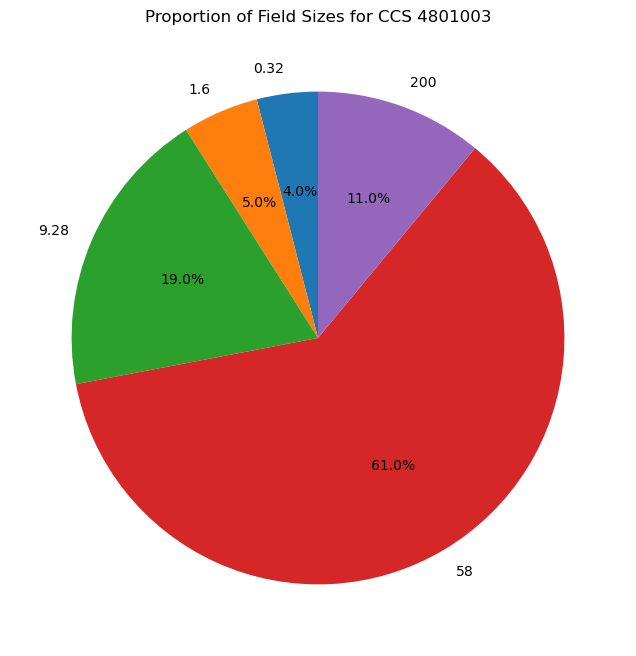

In [13]:
import matplotlib.pyplot as plt

# Choose CCS to visualize

ccs_choice = CCSUID[0]  # replace with desired CCS
k_choice = K[0]

# Aggregate total fields per size

size_totals = {s: 0 for s in S}

for r in S:
    # Sum over all crops, previous crops (l), previous fields (j), rotations (r), years (k)
    size_totals[r] = sum(x[ccs_choice, j, s, l, r, k_choice].X for j in J for l in J for s in S)

# Compute proportions

total = sum(size_totals.values())
proportions = [size_totals[s]/total for s in S]

# Plot pie chart

plt.figure(figsize=(8,8))
plt.pie(proportions, labels=[f'{Surface[s]}' for s in S], autopct='%1.1f%%', startangle=90)
plt.title(f'Proportion of Field Sizes for CCS {ccs_choice}')
plt.show()


In [15]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt

def build_sankey_focus_size(ccs_choice, s_focus, x, Crops, K, S):
    """
    Sankey diagram with:
    - Surface type 2 vs other
    - Cross flows allowed
    - Crop colors for type 2, grey for other
    - Years along x-axis
    """

    # -----------------------------
    # 1. COLOR MAPS
    # -----------------------------
    cmap = plt.get_cmap("tab20")
    crop_colors = {crop: cmap(i % 20) for i, crop in enumerate(Crops)}
    other_color = "rgba(180,180,180,0.35)"

    # -----------------------------
    # 2. BUILD NODES
    # -----------------------------
    nodes = []
    node_idx = {}
    node_x = []
    node_y = []
    idx = 0

    # Map years to x positions [0,1]
    year_pos = {k: i / (len(K)-1) for i, k in enumerate(K)}

    node_colors = []

    for k in K:
        for crop in Crops:
            # Type 2 node
            nodes.append("")
            node_idx[(crop, k, "type2")] = idx
            node_x.append(year_pos[k])
            node_y.append(None)  # vertical auto
            idx += 1
            node_colors.append("rgba(255,0,0,0.85)")

            # Other node
            nodes.append("")
            node_idx[(crop, k, "other")] = idx
            node_x.append(year_pos[k])
            node_y.append(None)
            idx += 1
            node_colors.append("rgba(180,180,180,0.35)")

    # -----------------------------
    # 3. BUILD LINKS
    # -----------------------------
    sources, targets, values, colors, labels = [], [], [], [], []

    for k_idx, k in enumerate(K[:-1]):
        next_k = K[k_idx + 1]

        for j, crop_j in enumerate(Crops):
            for l, crop_l in enumerate(Crops):
                for s_src in S:
                    for s_tgt in S:
                        flow = x[ccs_choice, j, s_src, l, s_tgt, k_idx].X * Surface[s_src]
                        if flow < 0.00001:
                            continue

                        src_cat = "type2" if s_src == s_focus else "other"
                        tgt_cat = "type2" if s_tgt == s_focus else "other"

                        sources.append(node_idx[(crop_j, k, src_cat)])
                        targets.append(node_idx[(crop_l, next_k, tgt_cat)])
                        values.append(flow)

                        # Link color
                        if src_cat == "type2" or tgt_cat == "type2":
                            r, g, b, a = crop_colors[crop_j]
                            colors.append(f"rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, {a})")
                        else:
                            r, g, b, a = crop_colors[crop_j]
                            colors.append(f"rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, 0.15)")

                        # Labels: only if type2 involved
                        if src_cat == "type2" or tgt_cat == "type2":
                            labels.append(f"{crop_j} → {crop_l} (type2 flow)")
                        else:
                            labels.append("")

    # -----------------------------
    # 4. CREATE FIGURE
    # -----------------------------
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=20,
            thickness=20,
            label=nodes,
            color=node_colors,
            line=dict(
                color="grey",          # border color
                width=0.1               # border thickness in pixels
            ),
            x=node_x,
            y=node_y
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=colors,
            label=labels,
            hovertemplate="%{label}<br>Flow: %{value}<extra></extra>"
        )
    )])

    # -----------------------------
    # 5. CUSTOM LEGEND FOR CROPS
    # -----------------------------
    legend_traces = []
    for crop in Crops:
        r, g, b, a = crop_colors[crop]
        legend_traces.append(go.Scatter(
            x=[None], y=[None],
            mode='markers',
            marker=dict(size=15, color=f"rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, {a})"),
            showlegend=True,
            name=crop
        ))

    for trace in legend_traces:
        fig.add_trace(trace)

    # -----------------------------
    # 6. ANNOTATIONS FOR YEARS (X-AXIS)
    # -----------------------------
    annotations = []
    for k, x_pos in year_pos.items():
        annotations.append(dict(
            x=x_pos,
            y=-0.05,  # below nodes
            xref="paper",
            yref="paper",
            text=f"Year {k}",
            showarrow=False,
            font=dict(size=12)
        ))

    # -----------------------------
    # 7. LAYOUT
    # -----------------------------
    fig.update_layout(
        title=f"Sankey Diagram for CCS {ccs_choice}<br>Surface type 2 vs Other (cross-flows)",
        font_size=12,
        height=900,
        plot_bgcolor='rgba(0,0,0,0)',
        xaxis=dict(showgrid=False, zeroline=False, visible=False),
        yaxis=dict(showgrid=False, zeroline=False, visible=False),
        annotations=annotations,
        legend=dict(
            title="Crop Colors",
            x=1.05,
            y=1.0,
            bordercolor="rgba(0,0,0,0.3)",
            borderwidth=1,
            itemsizing="constant",
            font=dict(size=12)
        )
    )

    fig.show()


# ---------------------------
# Example Use
# ---------------------------
ccs_choice = CCSUID[0]
s_focus = S[3]  # surface type 2
build_sankey_focus_size(ccs_choice, s_focus, x, Crops, K, S)